# Imports

In [1]:
import os
print(os.listdir("../input"))

!git clone https://github.com/mebn/ultralytics.git
!cd ultralytics && git pull && cd ..

import torch
import torchvision
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models.feature_extraction import create_feature_extractor
import cv2
import matplotlib.pyplot as plt

import sys
sys.path.append("/kaggle/working/ultralytics")
from ultralytics import YOLO

['seadronessee-yolo-500']
Cloning into 'ultralytics'...
remote: Enumerating objects: 36449, done.
remote: Total 36449 (delta 0), reused 0 (delta 0), pack-reused 36449 (from 1)
Receiving objects: 100% (36449/36449), 22.19 MiB | 14.67 MiB/s, done.
Resolving deltas: 100% (26319/26319), done.
Already up to date.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Replacing backbone and initialization

In [2]:
model_file = "/kaggle/working/model.yaml"


with open(model_file, "w") as f:
    f.write("""
nc: 80  # number of classes

scales:
  n: [1, 1, 1024]  # actual architecture below is scaled to match n: [0.5, 0.25, 1024]

backbone:
  - [-1, 1, TorchVision, [464, shufflenet_v2_x1_0, DEFAULT, True, 2, True]] # 0

head:
  - [0, 1, Index, [116, 5]]           # 1: P3
  - [1, 1, CA, [116]]                 # 2
  - [0, 1, Index, [232, 6]]           # 3: P4
  - [3, 1, CA, [232]]                 # 4
  - [0, 1, Index, [464, 7]]           # 5: P5
  - [5, 1, CA, [464]]                 # 6

  # Project to scaled YOLOv11 channel sizes (256 → 64, 512 → 128, 1024 → 256)
  - [2, 1, Conv, [64, 1, 1]]         # 7: P3 → 64
  - [4, 1, Conv, [128, 1, 1]]        # 8: P4 → 128
  - [6, 1, Conv, [256, 1, 1]]        # 9: P5 → 256

  # FPN: P5 → P4
  - [9, 1, nn.Upsample, [None, 2, "nearest"]]  # 10
  - [[10, 8], 1, Concat, [1]]                  # 11
  - [-1, 1, C3k2, [128, False]]                # 12 (2 → 1 repeat, 512 → 128)

  # FPN: P4 → P3
  - [12, 1, nn.Upsample, [None, 2, "nearest"]]  # 13
  - [[13, 7], 1, Concat, [1]]                   # 14
  - [-1, 1, C3k2, [64, False]]                  # 15 (256 → 64)

  # PAN: P3 → P4
  - [15, 1, Conv, [64, 3, 2]]                   # 16
  - [[16, 12], 1, Concat, [1]]                  # 17
  - [-1, 1, C3k2, [128, False]]                 # 18

  # PAN: P4 → P5
  - [18, 1, Conv, [128, 3, 2]]                  # 19
  - [[19, 9], 1, Concat, [1]]                   # 20
  - [-1, 1, C3k2, [256, True]]                  # 21

  # Final detection layers
  - [[15, 18, 21], 1, Detect, [nc]]             # 22

  

  
# backbone layers:
# 0 torch.Size([1, 3, 640, 640])
# 1 torch.Size([1, 24, 320, 320])
# 2 torch.Size([1, 24, 320, 320])
# 3 torch.Size([1, 24, 320, 320])
# 4 torch.Size([1, 24, 160, 160])
# 5 torch.Size([1, 116, 80, 80])
# 6 torch.Size([1, 232, 40, 40])
# 7 torch.Size([1, 464, 20, 20])
""")


model = YOLO(model_file, task="detect")

# img = torch.randn(1, 3, 640, 640)
# output = model.model(img)
# for o in output:
#     print(o.shape)

WARNING ⚠️ no model scale passed. Assuming scale='n'.


Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 142MB/s]


# Data

In [3]:
data_file = "/kaggle/working/data.yaml"


with open(data_file, "w") as f:
    f.write("""train: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train
val: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/val
test: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test
nc: 1
names: ["human"]""")

# Fine-tuning

In [4]:
model.train(
    data=data_file,
    epochs=300,
    patience=15,
    imgsz=640,
    batch=16,
    name="model"
)

New https://pypi.org/project/ultralytics/8.3.115 available 😃 Update with 'pip install -U ultralytics'
WARNING ⚠️ 'name=model' automatically updated to 'name=/kaggle/working/model'.
Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/model.yaml, data=/kaggle/working/data.yaml, epochs=300, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=model, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=Fals

100%|██████████| 755k/755k [00:00<00:00, 4.60MB/s]
E0000 00:00:1745486597.795861      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745486597.846622      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=1
WARNING ⚠️ no model scale passed. Assuming scale='n'.

                   from  n    params  module                                       arguments                     
  0                  -1  1    776420  ultralytics.nn.modules.block.TorchVision     ['shufflenet_v2_x1_0', 'DEFAULT', True, 2, True]
  1                   0  1         0  ultralytics.nn.modules.conv.Index            [5]                           
  2                   1  1      3040  ultralytics.nn.modules.conv.CA               [116]                         
  3                   0  1         0  ultralytics.nn.modules.conv.Index            [6]                           
  4                   3  1      6056  ultralytics.nn.modules.conv.CA               [232]                         
  5                   0  1         0  ultralytics.nn.modules.conv.Index            [7]                           
  6                   5  1     20458  ultralytics.nn.modules.conv.CA               [464]   

100%|██████████| 5.35M/5.35M [00:00<00:00, 17.5MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/train... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:05<00:00, 95.96it/s] 

train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9563.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9565.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9569.jpg: 1 duplicate labels removed


train: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/val... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:02<00:00, 74.65it/s]


val: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/val/9560.jpg: 1 duplicate labels removed
val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.
WARNING ⚠️ 'name=model' automatically updated to 'name=/kaggle/working/model'.
Plotting labels to /kaggle/working/model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 102 weight(decay=0.0), 115 weight(decay=0.0005), 117 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/model
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      1/300      2.72G      4.103      69.03      3.858         27        640: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

                   all        200       1017          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      2/300      3.17G      4.193      9.392      2.227         52        640: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        200       1017          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      3/300      3.18G      3.737      4.345      1.524         26        640: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]


                   all        200       1017   0.000245     0.0108   0.000124   3.15e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      4/300      3.18G      3.416      3.424      1.353         27        640: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

                   all        200       1017    0.00648       0.29     0.0464    0.00997



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      5/300      3.18G      3.257      2.862      1.274         50        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]

                   all        200       1017      0.256     0.0953     0.0783     0.0157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      6/300      3.18G       3.18      2.619      1.234         30        640: 100%|██████████| 32/32 [00:12<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        200       1017      0.346      0.288      0.176     0.0356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      7/300      3.18G      3.125      2.494      1.246         39        640: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


                   all        200       1017      0.263      0.228      0.106      0.022

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      8/300      3.18G      3.084      2.286      1.211         39        640: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.42it/s]

                   all        200       1017      0.372      0.334      0.246     0.0552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      9/300      3.18G      3.052      2.206      1.235         21        640: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.32it/s]

                   all        200       1017      0.321      0.275      0.165     0.0344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     10/300      3.18G      3.028       2.02      1.228         48        640: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.18it/s]

                   all        200       1017      0.397      0.321      0.232     0.0489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     11/300      3.18G      2.985      1.987      1.154         14        640: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]

                   all        200       1017      0.388      0.296      0.216     0.0451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     12/300      3.18G       2.88      1.942       1.18         18        640: 100%|██████████| 32/32 [00:11<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.79it/s]

                   all        200       1017      0.453      0.349      0.256     0.0588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     13/300      3.18G      2.918       1.84      1.194         16        640: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.80it/s]

                   all        200       1017      0.497      0.354       0.29     0.0698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     14/300      3.18G      2.827       1.72      1.126         23        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.60it/s]

                   all        200       1017       0.49      0.348      0.273     0.0626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     15/300      3.18G      2.819      1.665      1.136         37        640: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]

                   all        200       1017      0.462      0.362      0.297     0.0823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     16/300      3.18G      2.899      1.705      1.163         46        640: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.79it/s]

                   all        200       1017      0.461      0.363      0.288     0.0717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     17/300      3.18G      2.796      1.571      1.132         38        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.24it/s]

                   all        200       1017      0.504      0.381      0.327     0.0847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     18/300      3.18G      2.767      1.532      1.179         33        640: 100%|██████████| 32/32 [00:12<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]

                   all        200       1017      0.544      0.397      0.362     0.0973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     19/300      3.18G      2.752      1.529      1.135         49        640: 100%|██████████| 32/32 [00:11<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.83it/s]

                   all        200       1017      0.563      0.401      0.367        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     20/300      3.18G      2.738      1.497      1.113         23        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.47it/s]

                   all        200       1017      0.499      0.419       0.35     0.0989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     21/300      3.18G      2.767      1.489      1.182         20        640: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.18it/s]

                   all        200       1017      0.548      0.421      0.367     0.0998



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     22/300      3.18G       2.66      1.391      1.133         20        640: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        200       1017      0.484      0.383      0.336     0.0915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     23/300      3.18G      2.717      1.401      1.097         21        640: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.89it/s]

                   all        200       1017      0.511      0.369      0.317     0.0769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     24/300      3.18G      2.717      1.401       1.11         29        640: 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        200       1017      0.505      0.402      0.317     0.0848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     25/300      3.18G      2.666      1.379      1.112         28        640: 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

                   all        200       1017      0.486      0.388      0.325     0.0865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     26/300      3.18G      2.666      1.358       1.14         26        640: 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


                   all        200       1017      0.547      0.397      0.368      0.104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     27/300      3.18G      2.714      1.382      1.094         47        640: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        200       1017      0.541      0.413      0.389      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     28/300      3.18G      2.635      1.332      1.109         32        640: 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        200       1017      0.607      0.412      0.414      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     29/300      3.18G      2.631      1.291      1.093         21        640: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.54it/s]

                   all        200       1017      0.623      0.413      0.416      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     30/300      3.18G      2.648      1.327       1.09         26        640: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.68it/s]

                   all        200       1017      0.541      0.401      0.377      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     31/300      3.18G      2.703      1.379      1.168         24        640: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        200       1017      0.547      0.406      0.353      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     32/300      3.18G      2.577      1.267      1.107         42        640: 100%|██████████| 32/32 [00:11<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.75it/s]

                   all        200       1017      0.555      0.382      0.347     0.0942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     33/300      3.18G      2.639      1.297      1.135         36        640: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.62it/s]

                   all        200       1017      0.571      0.391      0.394      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     34/300      3.18G      2.529      1.227      1.076         37        640: 100%|██████████| 32/32 [00:11<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        200       1017      0.542      0.411      0.384      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     35/300      3.18G      2.577      1.262        1.1         29        640: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]


                   all        200       1017      0.604        0.4       0.39      0.118

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     36/300      3.18G      2.598      1.254      1.057         32        640: 100%|██████████| 32/32 [00:13<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.19it/s]

                   all        200       1017      0.569      0.405      0.381      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     37/300      3.18G      2.561      1.258      1.073         25        640: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.23it/s]

                   all        200       1017      0.496      0.405      0.391      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     38/300      3.18G      2.538      1.219      1.076         41        640: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        200       1017      0.556      0.434      0.394      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     39/300      3.18G      2.493      1.197       1.06         25        640: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        200       1017       0.53      0.393      0.368      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     40/300      3.18G      2.518      1.205      1.091         28        640: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        200       1017      0.581      0.439      0.419      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     41/300      3.18G      2.502      1.182      1.072         47        640: 100%|██████████| 32/32 [00:13<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.36it/s]

                   all        200       1017      0.573      0.418      0.407      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     42/300      3.18G      2.417      1.127      1.094         30        640: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

                   all        200       1017      0.593      0.422      0.429       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     43/300      3.18G      2.486      1.172      1.045         22        640: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.85it/s]

                   all        200       1017      0.547        0.4      0.384      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     44/300      3.18G      2.514       1.19      1.118         32        640: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.47it/s]

                   all        200       1017      0.563      0.408      0.408      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     45/300      3.18G      2.448      1.164      1.033         41        640: 100%|██████████| 32/32 [00:11<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.64it/s]

                   all        200       1017      0.568       0.43      0.424      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     46/300      3.18G      2.438       1.13      1.047         36        640: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        200       1017      0.594      0.454      0.429      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     47/300      3.18G      2.445      1.135      1.052         30        640: 100%|██████████| 32/32 [00:11<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        200       1017      0.557      0.425      0.385      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     48/300      3.18G      2.476      1.136      1.026         40        640: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


                   all        200       1017      0.543      0.366      0.352     0.0991

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     49/300      3.18G      2.442       1.13      1.054         38        640: 100%|██████████| 32/32 [00:11<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.71it/s]

                   all        200       1017      0.524      0.429      0.405      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     50/300      3.18G      2.475      1.149      1.054         56        640: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]

                   all        200       1017      0.609      0.411      0.428      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     51/300      3.18G      2.412      1.139      1.038         36        640: 100%|██████████| 32/32 [00:11<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        200       1017      0.603        0.4      0.402      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     52/300      3.18G      2.459      1.142      1.056         27        640: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.93it/s]

                   all        200       1017      0.531      0.396      0.371      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     53/300      3.18G      2.436      1.108      1.017         57        640: 100%|██████████| 32/32 [00:10<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

                   all        200       1017       0.56      0.429       0.41      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     54/300      3.18G      2.391      1.119      1.071         33        640: 100%|██████████| 32/32 [00:11<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.33it/s]

                   all        200       1017      0.599      0.429      0.419      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     55/300      3.18G       2.44      1.118      1.103         21        640: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.42it/s]

                   all        200       1017      0.606      0.406      0.411      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     56/300      3.18G      2.423      1.097      1.048         44        640: 100%|██████████| 32/32 [00:11<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        200       1017      0.646      0.423       0.43      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     57/300      3.18G        2.4      1.133      1.029         11        640: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.44it/s]

                   all        200       1017      0.594      0.438      0.422      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     58/300      3.18G      2.394      1.097      1.056         36        640: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.90it/s]

                   all        200       1017      0.593      0.442      0.433      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     59/300      3.18G      2.292      1.069      1.056         38        640: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

                   all        200       1017       0.61      0.441      0.448      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     60/300      3.18G      2.289       1.06      1.042         51        640: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]

                   all        200       1017      0.585      0.451      0.449       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     61/300      3.18G       2.37      1.067      1.011         43        640: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        200       1017      0.614      0.443      0.461      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     62/300      3.18G      2.327      1.079      1.063         21        640: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        200       1017      0.587      0.443      0.442      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     63/300      3.18G      2.399      1.096      1.027         45        640: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]

                   all        200       1017      0.587       0.42      0.432      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     64/300      3.18G      2.322      1.047      1.032         27        640: 100%|██████████| 32/32 [00:11<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]

                   all        200       1017      0.647      0.421      0.428      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     65/300      3.18G      2.248      1.034      1.031         38        640: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.94it/s]

                   all        200       1017      0.571      0.408      0.388      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     66/300      3.18G      2.329      1.051      1.014         29        640: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.19it/s]

                   all        200       1017      0.547       0.42      0.389      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     67/300      3.18G       2.37      1.062      1.028         31        640: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]

                   all        200       1017      0.585      0.452      0.442      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     68/300      3.18G      2.345      1.066      1.045         30        640: 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        200       1017      0.591      0.415      0.419      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     69/300      3.18G      2.327      1.084      1.019         13        640: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]

                   all        200       1017      0.639      0.451      0.461      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     70/300      3.18G      2.323      1.103      1.005         23        640: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        200       1017      0.618      0.465      0.458      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     71/300      3.18G      2.318      1.055      1.023         51        640: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]

                   all        200       1017      0.612      0.476      0.464      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     72/300      3.18G       2.23      1.002      1.036         20        640: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.86it/s]

                   all        200       1017       0.58      0.433      0.424      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     73/300      3.18G      2.333      1.049      1.028         46        640: 100%|██████████| 32/32 [00:11<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

                   all        200       1017      0.649      0.448      0.462      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     74/300      3.18G      2.184      1.019      1.031         44        640: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.29it/s]

                   all        200       1017      0.578       0.46      0.448       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     75/300      3.18G      2.311      1.025      1.026         28        640: 100%|██████████| 32/32 [00:11<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        200       1017      0.601      0.433      0.429      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     76/300      3.18G      2.333      1.058      1.044         45        640: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]

                   all        200       1017      0.612      0.452      0.452      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     77/300      3.18G      2.262       1.03      1.015         19        640: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        200       1017       0.61      0.461      0.469       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     78/300      3.18G      2.263      1.028      1.074         33        640: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.65it/s]

                   all        200       1017      0.621      0.456       0.44      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     79/300      3.18G      2.271      1.006      1.044         31        640: 100%|██████████| 32/32 [00:11<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

                   all        200       1017      0.634      0.467      0.461      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     80/300      3.18G      2.318      1.038      1.008         24        640: 100%|██████████| 32/32 [00:10<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

                   all        200       1017      0.636      0.497      0.494      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     81/300      3.18G      2.173     0.9968      1.036         25        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        200       1017      0.646       0.45      0.455      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     82/300      3.18G      2.193       1.01       1.01         51        640: 100%|██████████| 32/32 [00:11<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        200       1017      0.615      0.491      0.475       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     83/300      3.18G      2.232      1.025     0.9887         40        640: 100%|██████████| 32/32 [00:12<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        200       1017      0.648      0.467      0.478      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     84/300      3.18G      2.219      1.007      1.011         48        640: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.81it/s]

                   all        200       1017      0.607      0.474      0.489      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     85/300      3.18G      2.255      1.019      1.029         56        640: 100%|██████████| 32/32 [00:11<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        200       1017      0.599      0.502      0.494      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     86/300      3.18G      2.225      1.012      1.011         43        640: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.38it/s]

                   all        200       1017      0.622      0.478      0.492      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     87/300      3.18G      2.195     0.9927      1.019         41        640: 100%|██████████| 32/32 [00:11<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        200       1017      0.584      0.406      0.432       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     88/300      3.18G      2.151      0.997      1.025         22        640: 100%|██████████| 32/32 [00:12<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        200       1017      0.635       0.45       0.46      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     89/300      3.18G        2.2     0.9863      1.026         60        640: 100%|██████████| 32/32 [00:12<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.36it/s]

                   all        200       1017      0.635      0.448      0.461      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     90/300      3.18G      2.125     0.9395     0.9912         53        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        200       1017      0.627       0.49      0.495      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     91/300      3.18G      2.238     0.9834     0.9821         25        640: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

                   all        200       1017      0.617      0.494       0.46      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     92/300      3.18G      2.161     0.9691      0.994         41        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        200       1017      0.597      0.446      0.457      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     93/300      3.18G      2.165     0.9794     0.9574         48        640: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.48it/s]

                   all        200       1017      0.627        0.5      0.501      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     94/300      3.18G      2.164      0.944     0.9896         42        640: 100%|██████████| 32/32 [00:11<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        200       1017      0.605      0.416      0.443      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     95/300      3.18G      2.219      1.003      1.009         16        640: 100%|██████████| 32/32 [00:11<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        200       1017      0.605      0.479      0.465      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     96/300      3.18G      2.181     0.9698     0.9888         28        640: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        200       1017      0.595      0.463       0.48       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     97/300      3.18G      2.063     0.9414     0.9858         17        640: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        200       1017      0.604      0.467      0.473      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     98/300      3.18G      2.112     0.9438     0.9843         28        640: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.30it/s]

                   all        200       1017      0.635      0.466      0.479      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     99/300      3.18G      2.106     0.9471      1.008         22        640: 100%|██████████| 32/32 [00:12<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]

                   all        200       1017      0.611      0.467      0.474      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
    100/300      3.18G      2.135     0.9994     0.9789         30        640: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.36it/s]

                   all        200       1017      0.636      0.496      0.502      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
    101/300      3.18G       2.11     0.9443     0.9842         18        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

                   all        200       1017      0.598      0.483      0.488       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
    102/300      3.18G      2.177     0.9395     0.9814         34        640: 100%|██████████| 32/32 [00:11<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.89it/s]

                   all        200       1017      0.647      0.486      0.516      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
    103/300      3.18G      2.063     0.9303     0.9665         22        640: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        200       1017       0.65      0.493      0.511      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
    104/300      3.18G      2.127     0.9372     0.9794         46        640: 100%|██████████| 32/32 [00:11<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.58it/s]

                   all        200       1017       0.62       0.48      0.493      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
    105/300      3.18G      2.151     0.9688     0.9751         54        640: 100%|██████████| 32/32 [00:11<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.24it/s]

                   all        200       1017      0.657      0.468        0.5      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
    106/300      3.18G      2.134     0.9754     0.9924         35        640: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]

                   all        200       1017      0.614      0.496      0.496       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
    107/300      3.18G      2.024      0.901     0.9824         30        640: 100%|██████████| 32/32 [00:11<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.20it/s]

                   all        200       1017      0.649      0.477      0.473      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
    108/300      3.18G          2      0.909      1.008         15        640: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        200       1017      0.662      0.479      0.506       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
    109/300      3.18G      2.025     0.9003     0.9606         33        640: 100%|██████████| 32/32 [00:11<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        200       1017       0.61      0.459      0.474      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
    110/300      3.18G      2.061     0.9009     0.9763         29        640: 100%|██████████| 32/32 [00:12<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]

                   all        200       1017      0.634      0.489      0.495      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
    111/300      3.18G      2.136     0.9281     0.9869         26        640: 100%|██████████| 32/32 [00:13<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]

                   all        200       1017      0.644      0.473       0.49      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
    112/300      3.18G      2.065     0.9117     0.9586         17        640: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.03it/s]

                   all        200       1017      0.595      0.445       0.47      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
    113/300      3.18G      2.049     0.9386      0.987         27        640: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        200       1017      0.647      0.467       0.51       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
    114/300      3.18G      2.137     0.9538     0.9809         30        640: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        200       1017        0.6      0.489      0.487      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
    115/300      3.18G      2.082     0.9363     0.9776         38        640: 100%|██████████| 32/32 [00:10<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.25it/s]

                   all        200       1017      0.561      0.474      0.479      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
    116/300      3.18G      2.087     0.9367     0.9735         27        640: 100%|██████████| 32/32 [00:11<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]

                   all        200       1017      0.615      0.442      0.464      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
    117/300      3.18G      2.026     0.9234     0.9821         58        640: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


                   all        200       1017      0.635      0.458      0.467      0.152
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 102, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

117 epochs completed in 0.489 hours.
Optimizer stripped from /kaggle/working/model/weights/last.pt, 4.7MB
Optimizer stripped from /kaggle/working/model/weights/best.pt, 4.7MB

Validating /kaggle/working/model/weights/best.pt...
Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
model summary: 245 layers, 2,179,289 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


                   all        200       1017      0.645      0.485      0.514      0.173


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /kaggle/working/model


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d1ccbc4ac90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Testing

In [5]:
def show_img_with_boxes(res):
    img = res[0].plot()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


image 1/1 /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test/10209.jpg: 384x640 4 humans, 61.1ms
Speed: 2.5ms preprocess, 61.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


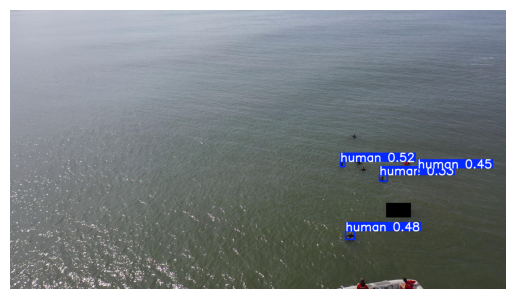

Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
model summary: 245 layers, 2,179,289 parameters, 0 gradients


val: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/test... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:02<00:00, 93.78it/s] 

val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


                   all        200       1072      0.679      0.572      0.581        0.2


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.9ms preprocess, 4.0ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /kaggle/working/ultralytics/runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d1ccaa3e590>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [6]:
model = YOLO("/kaggle/working/model/weights/best.pt")

img = "/kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test/10209.jpg"

results = model(img)
show_img_with_boxes(results)

model.val(
    data=data_file,
    split="test"
)